The Black-Scholes equation for asset price is given by
$$ 
dS_t = \mu \ S_t + \sigma S_t \ dW_t
$$
where $\sigma$ is the volatility and $dW_t$ is a Brownian motion. Importantly, $\sigma$ is assumed to be constant. This implies that the distribution of the log return is a Gaussian. However, this contradicts real world data - the volatility is time dependent and the return distributions are not normal. They are asymmetric and heavy tailed.

The Heston model is a useful generalization that accommodates a time-dependent volatility which obeys another stochastic differential equation (SDE). The model equations are
$$
dS_t = \mu \ S_t dt + \sqrt{v_t} S_t \ dW_t^{(1)}
$$
$$
dv_t = \kappa \ (\theta - v_t) \ dt + \sigma \sqrt{v_t} \ dW_t^{(2)}
$$
The Brownian motions are correlated i.e. 
$$
corr(dW_t^{(1)} \ dW_t^{(2)}) = \rho \ dt
$$
$v_t$ is the instantaneous variance of $S_t$ and $\mu$ is the drift of the asset price. $\theta$ is the mean of $v_t$ at long times. Note that the first term on the right side of the $v_t$ equation is a mean-reverting term. This means that any deviation of $v_t$ away from $\theta$ decays with time. At long times, $v_t$ performs small random motions about $\theta$. The time scale over which this occurs is $1/\kappa$. Finally, $\sigma$ is the standard deviation of the volatility $v_t$ (also known as vol-of-vol).

## Implementation
The two equations are discretized according to the Euler-Maruyama scheme. 
$$
S_{t+dt} = S_t + \mu \ S_t dt + \sqrt{v_t} S_t \ dW_t^{(1)}
$$
$$
v_{(t+dt)} = v_t \kappa \ (\theta - v_t) \ dt + \sigma \sqrt{v_t} \ dW_t^{(2)}
$$
The correlated Brownian noise is obtained in the following way. We define two independent Brownian increments $dW_t^{(1)}$ and $dz_t$ drawn from the normal distribution $\mathcal{N}(0, dt)$. The increment $dW_t^{(2)}$ is defined as
$$
dW_t^{(2)} = \rho dW_t^{(1)} + \sqrt{1-\rho^2} dZ_t
$$
It can be shown that this definition ensures that $corr(dW_t^{(1)} \ dW_t^{(2)}) = \rho \ dt$. Finally, the Feller condition ensures that $v_t$ is always non-negative.
$$
2 \kappa \theta \geq \sigma^2
$$
## Potential numerical issues
The volatility $v_t$ can sometimes take negative values even if the Feller condition is satisfied. This is usually due to discretization errors. The easiest way to fix this is to reset the volatility to zero whenever it takes on a negative value. 

## Return
An important quantity of interest is the log return $r$. The log return over a time period $T$ is defined as
$$
r = \text{log}(\frac{S_T}{S_0})
$$
where $S_T$ is the asset price at time $t = T$ and $S_0$ is the initial asset price. In the following, I show the implementation of the Heston model and study the distributions of log returns as a function of model parameters.

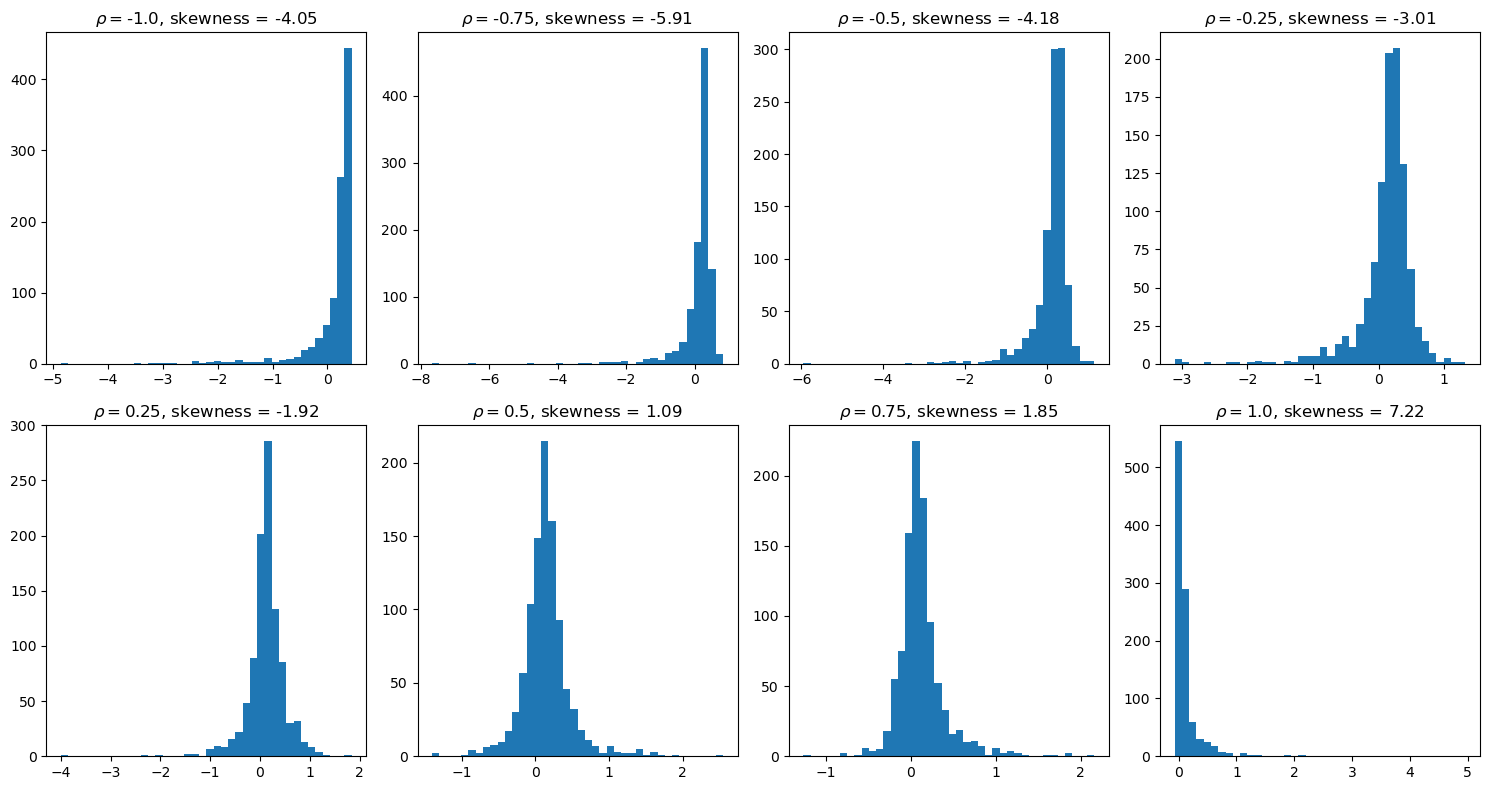

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import norm, kurtosis

def corr_brown(rho, dt):        #correlated Brownian motion
    dw1 = np.random.normal(0, np.sqrt(dt))
    dz = np.random.normal(0, np.sqrt(dt))
    dw2 = rho * dw1 + np.sqrt(1 - rho**2) * dz
    return dw1, dw2

def heston(t_arr, mu, sigma, kappa, theta, rho, v0, s0):
    s = np.zeros((num_steps, num_traj))
    s[0] = s0
    v = np.zeros((num_steps, num_traj))
    v[0] = v0
    for j in range(num_traj):
        for i in range(len(t_arr)-1):
            dw1, dw2 = corr_brown(rho_arr[k], dt)
            v[i+1, j] = max(v[i, j], 0) + kappa * (theta - max(v[i, j], 0)) * dt + sigma * np.sqrt(max(v[i, j], 0)) * dw2
            s[i+1, j] = s[i, j] + mu * s[i, j] * dt + np.sqrt(max(v[i, j], 0)) * s[i, j] * dw1
    return v, s

#total time of integration
T = 2
#time step
dt = 0.005
# time array
t_arr = np.arange(0, T+dt, dt)

#parameter values
mu = 0.1
sigma = 1.5 
kappa = 1   
theta = 0.04    
rho_arr = np.array([-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1])   #array of rho values. loop through these values to study effect of rho on return distribution
#matrix to store paths
num_steps = len(t_arr) #number of time steps in each path
num_traj = 1000    #number of paths

skewness = np.zeros(len(rho_arr))    #array to store skewness of return distribution as a function of rho

fig, axs = plt.subplots(2, 4, figsize=(15, 8))
# Flatten the axs array for easy looping
axs = axs.flatten()

for k in range(len(rho_arr)):
    V, S = heston(t_arr, mu, sigma, kappa, theta, rho_arr[k], v0=0, s0=0.1)
    r = np.log(S[-1]/S[0]) #return
    skewness[k] = skew(r.flatten())
    
    #return distribution for each rho
    axs[k].hist(r.flatten(), bins=40)
    axs[k].set_title('$\\rho = $'+str(rho_arr[k]) + ', skewness = '+"{:.2f}".format(skewness[k]))

plt.tight_layout()
plt.show()
    

In [ ]:
#%% plotting sample paths
plt.figure()
plt.xlabel('t')
plt.ylabel('S(t)')
plt.plot(t_arr, s[:,0])
plt.plot(t_arr, s[:,500])
plt.plot(t_arr, s[:, -1])
plt.show()

We see that $\rho$ governs the asymmetry of the return distribution. The asymmetry is quantified through the skewness i.e. the third standardized moment REF. In general, the distributions go from having negative skew to positive skew as $\rho$ is varied from -1 to 1. 

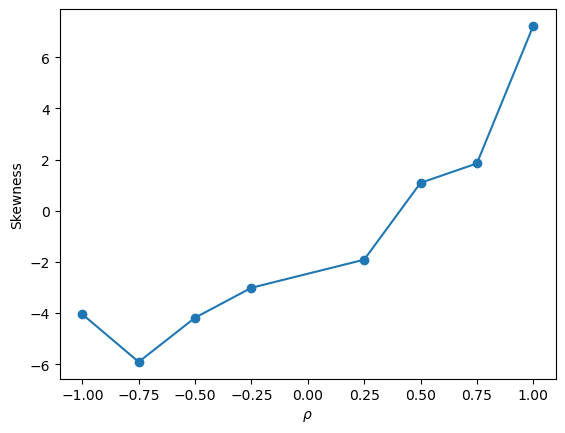

In [40]:
# plotting skewness as a function of rho
plt.figure()
plt.xlabel('$\\rho$')
plt.ylabel('Skewness')
plt.plot(rho_arr, skewness, 'o-')
plt.show()

## Fat tails
The distributions above have "fat tails", i.e. the distributions are non-negligible at large negative or large positive values. A good measure of the "tailedness" of the distributions is the kurtosis. The kurtosis of a distribution is the fourth standardised moment.

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kq/cm_511m56gq11vk14rgpfqk40000gn/T/ipykernel_16315/2422507665.py:14: SyntaxWarning: invalid escape sequence '\s'
  axs[k].set_title('$\sigma = $'+str(sigma_arr[k]) + ', kurtosis = '+"{:.2f}".format(kurt[k]))


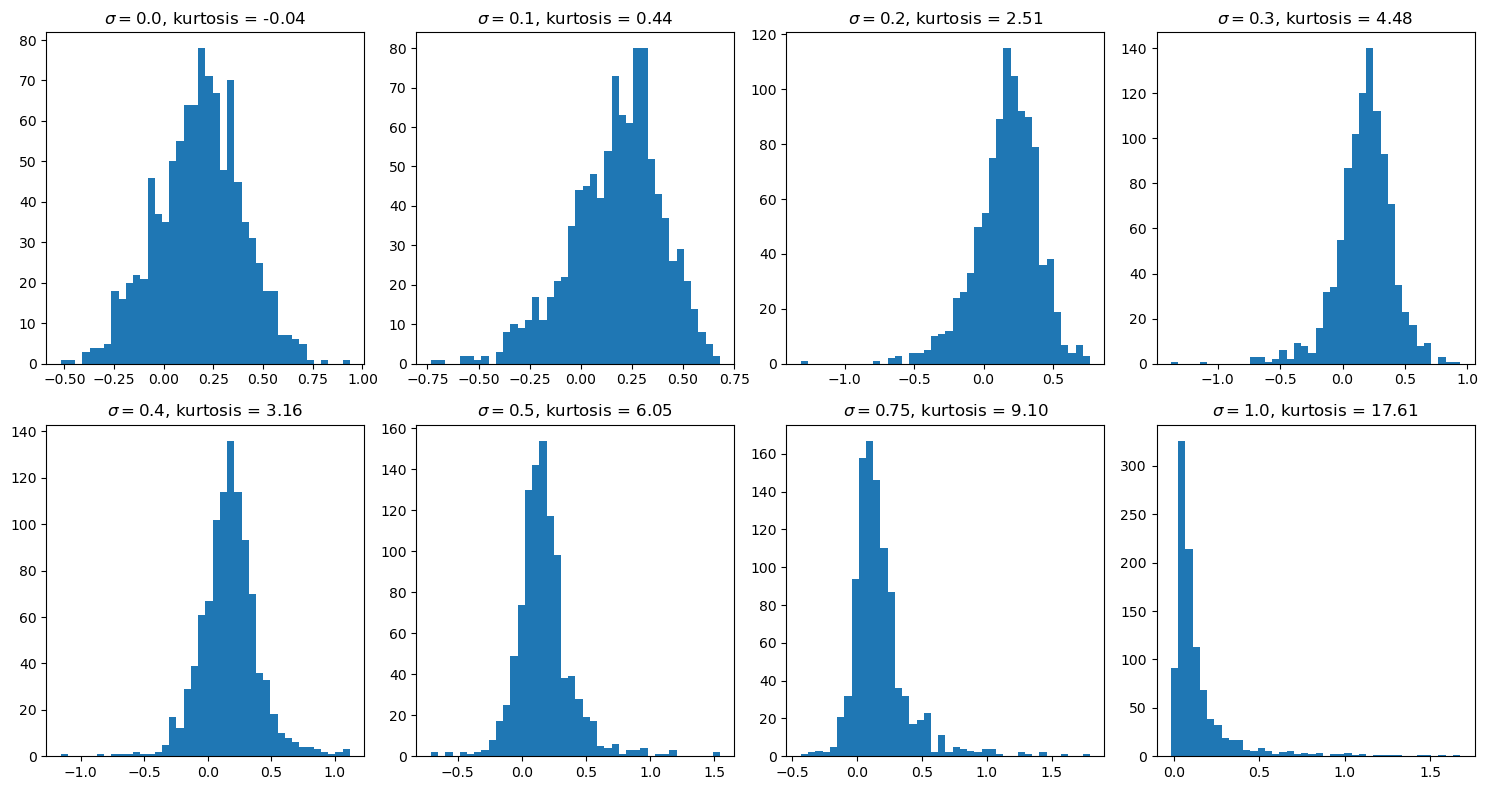

In [51]:
sigma_arr = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1])  # array of sigma values to loop over
rho = 0.5  # fix rho while varying sigma
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
# Flatten the axs array for easy looping
axs = axs.flatten()
kurt = np.zeros(len(sigma_arr))
for k in range(len(sigma_arr)):
    V, S = heston(t_arr, mu, sigma_arr[k], kappa, theta, rho, v0=0, s0=0.1)
    r = np.log(S[-1]/S[0])
    kurt[k] = kurtosis(r.flatten())
    
    #return distribution for each sigma
    axs[k].hist(r.flatten(), bins=40)
    axs[k].set_title('$\sigma = $'+str(sigma_arr[k]) + ', kurtosis = '+"{:.2f}".format(kurt[k]))
    
plt.tight_layout()
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/kq/cm_511m56gq11vk14rgpfqk40000gn/T/ipykernel_16315/440123986.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma$')


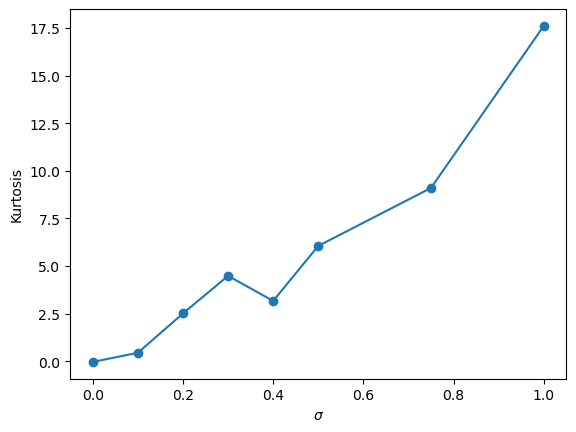

In [57]:
# plot kurtosis as a function of sigma
plt.figure()
plt.xlabel('$\sigma$')
plt.ylabel('Kurtosis')
plt.plot(sigma_arr, kurt, 'o-')
plt.show()